In [1]:
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from stateinterpreter.MD import Loader
from stateinterpreter.classifier import Classifier
from stateinterpreter.plot import plot_cvpath, plot_states, plot_combination_cvs_relevant_features


In [2]:
BPTI_data_path = '../../../data/md_datasets/BPTI-unbiased/'
colvar_file = BPTI_data_path + 'COLVAR'
traj_dict = {
        'trajectory' : BPTI_data_path+'all_trj_10ns.trr',
        'topology' : BPTI_data_path+'bpti-protein.pdb'
    }
# Compute descriptors from Trajectory
data = Loader(colvar_file, kbt=2.5)
data.load_trajectory(traj_dict)

../../stateinterpreter/MD.py:531: RuntimeWarning: invalid value encountered in true_divide
  return (1 - np.power(((x - d0) / r0), n)) / (1 - np.power(((x - d0) / r0), m))


In [3]:
data.colvar.head()

,idx,time,tica1,tica2,tica3,tica4
0,0,0,-0.982801,-0.716074,0.389900,0.327771
1,1,10,-0.979912,-0.723365,0.387473,0.351203
2,2,20,-0.984596,-0.789099,0.373603,0.412480
3,3,30,-0.983106,-0.656217,0.362498,0.377442
4,4,40,-0.978690,-0.702676,0.394956,0.366500


In [4]:
cv_list = ['tica1', 'tica2']
bounds = [(-1,1), (-1,1)]
data.identify_states(cv_list, bounds)

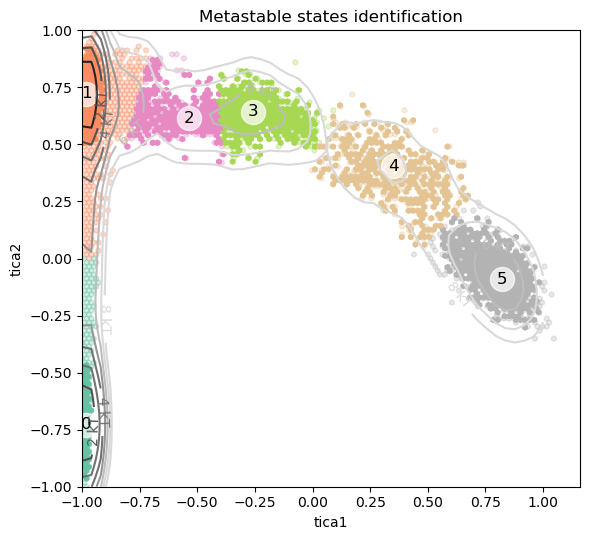

In [5]:
plot_states(data, fes_isolines=True)

In [6]:
for idx in range(data.n_basins):
    l = len(data.basins.loc[ (data.basins['basin'] == idx) & (data.basins['selection'] == True)])
    print(f"{idx} -> {l}")

0 -> 26059
1 -> 70332
2 -> 593
3 -> 857
4 -> 415
5 -> 931


In [7]:
descriptors = data.collect_data()
select_feat = 'sin_|cos_'
sample = data.sample(400, regex_filter = select_feat)

In [8]:
sample.configurations.shape

(2400, 390)

In [9]:
import re
def get_residue(s):
    m = re.search(r'\d+$', s)
    return m.group() if m else None

def _get_angle_groups(angle_names):
    groups = []
    for s in angle_names:
        groups.append(get_residue(s))
    return np.array(groups, dtype=int)

In [10]:
groups = _get_angle_groups(sample.features)
regularizers = np.geomspace(0.01, 1, 25)
dset = sample.train_test_dataset()
classifier = Classifier(dset, sample.features)
classifier.compute(regularizers, max_iter= 100000, groups=groups)

(-2.0, 0.0)

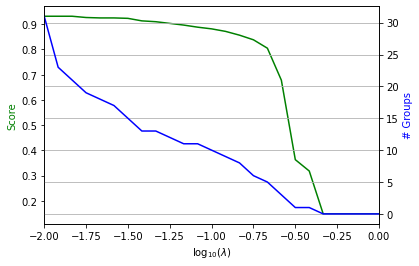

In [12]:
num_groups = []
for reg in regularizers:
    selected = classifier._get_selected(reg)
    unique_idxs = set()
    for state in selected:
        for data in state:
            unique_idxs.add(data[0])
    num_groups.append(len(unique_idxs))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax2.grid()
ax2.plot(np.log10(regularizers), num_groups, 'b-')
ax1.plot(np.log10(regularizers), classifier._crossval, 'g-')
#ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

ax1.set_xlabel(r"$\log_{10}(\lambda)$")
ax1.set_ylabel('Score', color='g')
ax2.set_ylabel('# Groups', color='b')
ax1.set_xlim(np.log10(regularizers)[0],np.log10(regularizers)[-1])


State 0:
	 47.55%  | 42
	 21.556% | 38
	 12.298% | 10
	 6.173%  | 39
	 4.393%  | 6
	 4.128%  | 36
	 2.518%  | 14
	 0.723%  | 13
	 0.625%  | 35
	 0.037%  | 9
State 1:
	 69.854% | 42
	 9.894%  | 6
	 5.555%  | 38
	 5.251%  | 39
	 4.519%  | 36
	 2.899%  | 10
	 1.725%  | 14
	 0.227%  | 35
	 0.065%  | 13
	 0.011%  | 9
State 2:
	 60.678% | 6
	 26.325% | 42
	 7.369%  | 10
	 1.444%  | 14
	 1.411%  | 39
	 1.167%  | 36
	 1.114%  | 38
	 0.361%  | 13
	 0.085%  | 35
	 0.046%  | 9
State 3:
	 34.722% | 6
	 22.751% | 10
	 16.37%  | 36
	 15.61%  | 42
	 4.454%  | 38
	 3.534%  | 14
	 1.152%  | 39
	 0.802%  | 13
	 0.337%  | 35
	 0.269%  | 9
State 4:
	 50.991% | 6
	 25.182% | 42
	 10.04%  | 10
	 7.46%   | 36
	 2.633%  | 39
	 1.66%   | 38
	 0.706%  | 14
	 0.599%  | 13
	 0.559%  | 35
	 0.17%   | 9
State 5:
	 33.117% | 6
	 21.841% | 36
	 16.713% | 42
	 8.594%  | 14
	 8.587%  | 10
	 6.234%  | 38
	 2.985%  | 39
	 1.183%  | 35
	 0.674%  | 13
	 0.071%  | 9


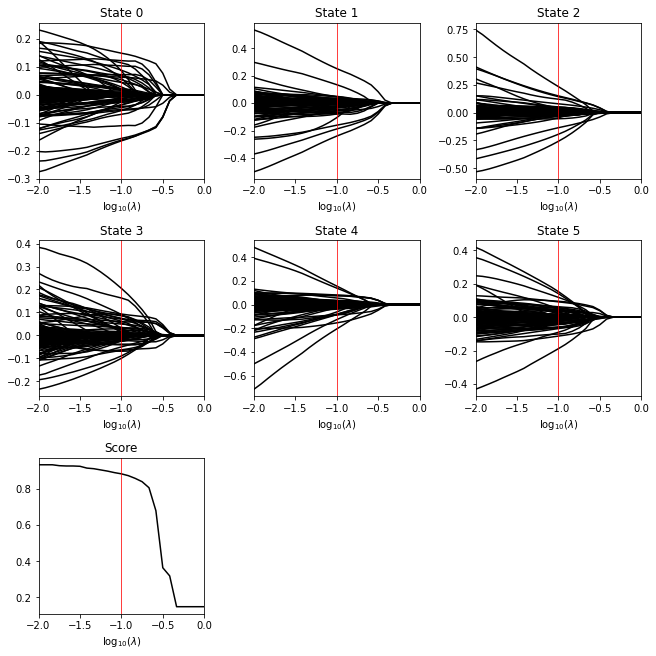

In [17]:
reg = 10**(-1)
plot_cvpath(classifier, reg);
classifier.print_selected(reg)